# Real-Time Analysis Using MediaPipe



 For accurate pose estimation, MediaPipe integrates a set of 33 well-selected landmarks positioned throughout the human body. The shoulder, elbow, wrist, hip, ankle, and knee are among the crucial locations covered by these landmarks, which guarantee a thorough depiction of body posture. Due to its versatility, the framework can be used for a variety of purposes, such as augmented reality and fitness tracking. With the help of precise calculations of joint angles, movement trajectories, and overall body posture made possible by each landmark's unique index, real-time feedback and insights can be obtained.



**MediaPipe Landmarks**
*   The 33 landmarks are shown below:







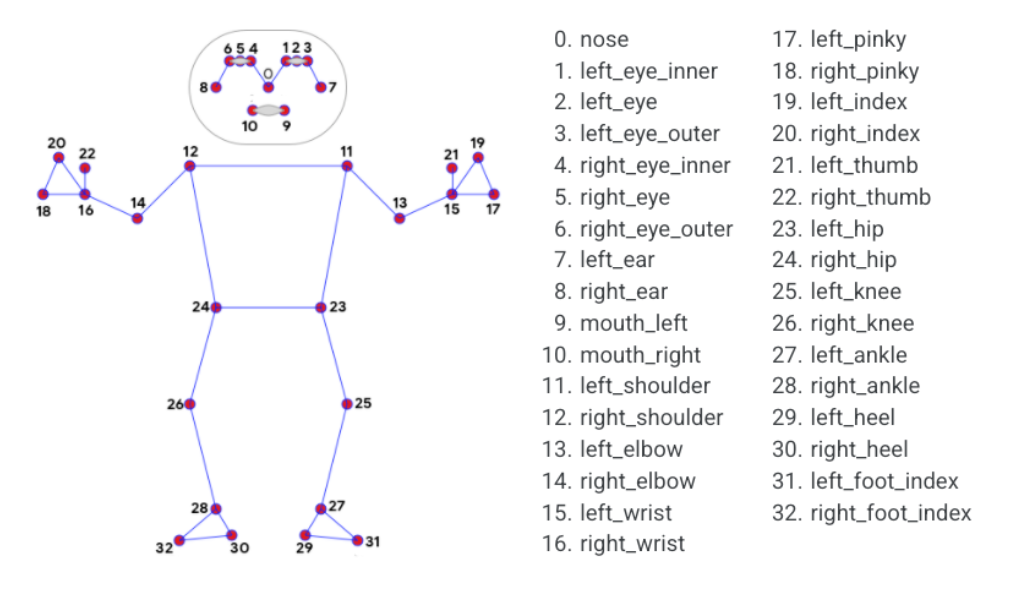

## Load Libraries and Exercise List

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import math
import os
from tensorflow.keras.models import load_model
from collections import deque
import itertools
import sys
draw_mp = mp.solutions.drawing_utils
pose_mp = mp.solutions.pose


#initial specs
IMAGE_HEIGHT , IMAGE_WIDTH = 128, 128

SEQUENCE_LENGTH = 20

#CLASSES_LIST = ['overheadpress', 'squats', 'curls']

CLASSES_LIST = ['pushups', 'squats', 'curls', 'overhead']

## Angle Calculation

This `angle_in_joints` function is used to compute the angle formed between three keypoints.

***Parameters***:

- **x, y, z**: Three points later converted into np arrays, where `x`,`y`and `z` are start, mid and end points, respectively.

In [2]:
#angle calculation
def angle_in_joints(x,y,z):
    x = np.array(x) # First point
    y = np.array(y) # Mid point
    z = np.array(z) # End point

    angle_1 = np.arctan2(z[1]-y[1], z[0]-y[0])
    angle_2 = np.arctan2(x[1]-y[1], x[0]-y[0])

    #taken help of a refrence code to calculate angles [mentioned in report].
    angle = angle_1 - angle_2
    angle_deg = np.abs(angle*180.0/np.pi)

    if angle_deg <= 180.0:
        pass
    elif angle_deg > 180.0:
        angle_deg = 360-angle_deg

    return angle_deg

## Landmark/Keypoint Co-ordinates
 This function `get_coordinates2` is to calculate the coordinates of a keypoint/landmark. It returns the coordinates in [x,y] format. To use this function, we specify the body part or keypoint of interest using the keyword `value`.

 For example, `landmarks[pose_mp.PoseLandmark.LEFT_SHOULDER.value].x` and `landmarks[pose_mp.PoseLandmark.LEFT_SHOULDER.value].y` would provide the x and y coordinates of the left shoulder.


In [3]:
def get_coordinates2(landmarks, exercise, flag):

    if exercise == 'exe':
        #print("bi")
        sh = [landmarks[pose_mp.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[pose_mp.PoseLandmark.LEFT_SHOULDER.value].y] #first point
        el = [landmarks[pose_mp.PoseLandmark.LEFT_ELBOW.value].x,landmarks[pose_mp.PoseLandmark.LEFT_ELBOW.value].y] #mid point
        wr = [landmarks[pose_mp.PoseLandmark.LEFT_WRIST.value].x,landmarks[pose_mp.PoseLandmark.LEFT_WRIST.value].y] #end point

        hi = [landmarks[pose_mp.PoseLandmark.LEFT_HIP.value].x,landmarks[pose_mp.PoseLandmark.LEFT_HIP.value].y] #first point
        kn = [landmarks[pose_mp.PoseLandmark.LEFT_KNEE.value].x,landmarks[pose_mp.PoseLandmark.LEFT_KNEE.value].y] #mid point
        an = [landmarks[pose_mp.PoseLandmark.LEFT_ANKLE.value].x,landmarks[pose_mp.PoseLandmark.LEFT_ANKLE.value].y] #end point


    return sh,el,wr, hi,kn,an



This function detects human pose estimation keypoints from webcam footage. Also, the RGB image is processed using the `pose.process` method, which extracts keypoints that correspond to landmarks on the detected pose.


In [4]:
def media_pipe_detection(frame, pose):

    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img.flags.writeable = False

    key_pts = pose.process(img)

    img.flags.writeable = True
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    #print(key_pts)
    return key_pts,img


The `status_box` function below is responsible for showing a rectangular status box on the input image. This is where the user gets to know rep count and rep stage (up or down) of the exercise.

In [5]:
#creating a box for rep count
def status_box(img, cntr, stg):

    cv2.rectangle(img, (0,0), (300,73), (245,117,16), -1)

    cv2.putText(img,'REPS', (15,12),cv2.FONT_HERSHEY_COMPLEX, 0.5, (0,0,0), 1)
    cv2.putText(img, str(cntr),(10,60),cv2.FONT_HERSHEY_COMPLEX, 2, (255,255,255), 2)


    cv2.putText(img,'STAGE', (65,12),cv2.FONT_HERSHEY_COMPLEX, 0.5, (0,0,0), 1)
    cv2.putText(img, stg, (90,60),cv2.FONT_HERSHEY_COMPLEX, 2, (255,255,255), 2)


In [6]:
def frame_preprocess(frame,pose):

    #creating bounding box
    res=pose.process(frame)
    landmarks = []
    x_min = float('inf')
    y_min = float('inf')
    x_max = float('-inf')
    y_max = float('-inf')



    #detecting landmarks
    if res.pose_landmarks:
                landmarks = res.pose_landmarks.landmark

    for landmark in landmarks:
                x, y, _ = int(landmark.x * frame.shape[1]), int(landmark.y * frame.shape[0]), landmark.z
                x_min = min(x_min, x)
                y_min = min(y_min, y)
                x_max = max(x_max, x)
                y_max = max(y_max, y)

    #creating default bounding box to evade negative values
    if x_min == float('inf') or y_min == float('inf'):
        x_min, y_min, x_max, y_max = 0, 0, 50, 50
    elif x_max == float('-inf') or y_max == float('-inf'):
        x_min, y_min, x_max, y_max = 0, 0, 50, 50


    # print("x,y:min:",x_min,y_min)


    cv2.rectangle(frame, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

    resize = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
    normalized = resize / 255


    #cv2.imshow('Bounding Box', frame)
    return normalized

In [7]:
def preprocess(frames,pose):
    # Reshape and preprocess each frame in the sequence
    processed_frames = []

    for frame in frames:
        temp = frame_preprocess(frame,pose)
        processed_frames.append(temp)

    seq_prcsd = np.array(processed_frames)
    #print("Processed Sequence Shape Before Reshape:", seq_prcsd.shape)
    #print("Processed Sequence Size Before Reshape:", seq_prcsd.size)
    final = np.reshape(seq_prcsd, (1, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    return final

After loading our model, `predict_exercise` predicts the exercise of the user from 'class list'(overheadpress, squats, curls) and returns the value to `user_exercise` function.

In [8]:
def predict_exercise(model, frame_queue,pose):

    result_seq = preprocess(frame_queue,pose)

    prediction = model.predict(result_seq)[0]
    #print("prediction",prediction)
    predicted_class = np.argmax(prediction)
    print("predicted_class",predicted_class)
    result=CLASSES_LIST[predicted_class]
    return result

# User Exercise

### Real-Time Exercise Detection

The `user_exercise` function uses a pre-trained model (`model`) and the MediaPipe library for pose estimation (`pose`) to perform real-time exercise detection on a video feed that has been captured from a designated capture device (`cap`). It processes a series of frames using a frame queue, postponing the start of analysis to give stability.

With the addition of pose estimation, joint angle computations, and exercise repetition counting, this function offers a complete real-time exercise monitoring solution. The primary steps consist of:

1. **Frame Processing:** Frames are continuously read from the video feed, with an initial delay to stabilize the detection.

2. **Pose Estimation:** MediaPipe is used to detect pose landmarks of the user. We later call `get_coordinates2` function where we extract coordinates(in [x,y] format) of the relevant landmarks/keypoints.

3. **Angle Calculation:** Joint angles(mid point) are calculated using the extracted coordinates, particularly focusing on the elbow and hip angles. We call `angle_in_joints` function and pass three keypoints to it where it returns live angle.

4. **Exercise Repetition Counting:** The function incorporates some logic to count exercise repetitions based on the detected joint angles. There's a threshold value used here to count reps.

5. **Visualization:** We call `status_box` function where we annotate the image/frame with relevant information, such as the detected exercise, and exercise rep count and stage of the rep(up or down).

6. **Exit:** The real time analysis exits/stops when the user presses the 'q' key.



In [9]:
def user_exercise(cap, pose,model):

        frame_count = 0
        delay_frames = 300
        framequeue = deque(maxlen=SEQUENCE_LENGTH)

        # Curl counter variables
        counter = 0
        stage = None
        #print("1")
        while cap.isOpened():
            ret, frame = cap.read()
            #print("2")

            if frame_count < delay_frames:
                frame_count += 1
                continue


            #print("Processed Frame Shape:", frame_preprocess.shape)

            framequeue.append(frame)
            #framequeue = deque(maxlen=SEQUENCE_LENGTH)
            #framequeue = deque(itertools.islice(framequeue, SEQUENCE_LENGTH))
            #print("Frame Queue Size:", len(framequeue))
            #print("Contents of Frame Queue:", framequeue)

            if len(framequeue) == SEQUENCE_LENGTH:
                prediction = predict_exercise(model, framequeue,pose)
                cv2.putText(frame, f"Exercise: {prediction}", (10, 100), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2,cv2.LINE_AA)
                print(f"Action: {prediction}")
            # Make keypoints detection
            results,image = media_pipe_detection(frame, pose)

            # Extract landmarks
            try:
                landmarks = results.pose_landmarks.landmark

                # Get coordinates
                sh,el,wr, hi,kn,an = get_coordinates2(landmarks, 'exe', None)
                #print(sh,el,wr, hi,kn,an)

                # Calculate angle
                angle = angle_in_joints(sh, el, wr)
                #print("angle:",angle)
                angle2= angle_in_joints(sh, hi, kn)
                #angle3= angle_in_joints(sh, hi, kn)
                # Visualize angle
                cv2.putText(image, str(angle),tuple(np.multiply(el, [640, 480]).astype(int)),cv2.FONT_HERSHEY_COMPLEX, 0.5, (255, 255, 255), 2)

                # Curl counter logic/ curl/shoulder
                if angle > 130:
                    stage = "down"
                if angle < 30 and stage =='down':
                    stage="up"
                    counter =counter + 1
                    print(counter)



            except:
                pass

            # calling status box [rep and stage]
            status_box(image, counter,stage)

            # Render detections
            draw_mp.draw_landmarks(image, results.pose_landmarks, pose_mp.POSE_CONNECTIONS,
                                    draw_mp.DrawingSpec(color=(200,150,60), thickness=2, circle_radius=2),
                                    draw_mp.DrawingSpec(color=(200,150,60), thickness=2, circle_radius=2)
                                    )

            cv2.imshow('Exercise', image )
            #cv2.imshow('Mediapipe',image)
            #cv2.imshow('Bounding Box', image)
            #Exit
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break


        cap.release()
        cv2.destroyAllWindows()




# Accessing Webcam

 This is where the program starts. The `main` Function is used to access the PC's webcam. Also, this is where to load the 3D cnn model from the 'h5' file from the current directory.

*   Note: The .pynb file and the .h5 file should preferably be in the same directory.

In [10]:
def main():

    cap = cv2.VideoCapture(0)

    ## Setup mediapipe instance
    with pose_mp.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        current_directory = os.getcwd()
        #model_filename = "high.h5"
        model_filename = "cnn3d1.0.h5"
        model_path = os.path.join(current_directory, model_filename)
        model = load_model(model_path)

        decision = input("Open video cam? (y/n):")

        if decision == 'y' or decision =='Y':
            user_exercise(cap, pose,model)

        else:
            sys.exit()
main()



Open video cam? (y/n): y


1/1 [==============================] - 0s 465ms/step
predicted_class 1
Action: squats
1/1 [==============================] - 0s 168ms/step
predicted_class 1
Action: squats
1/1 [==============================] - 0s 155ms/step
predicted_class 1
Action: squats
1/1 [==============================] - 0s 130ms/step
predicted_class 1
Action: squats
1/1 [==============================] - 0s 139ms/step
predicted_class 1
Action: squats
1/1 [==============================] - 0s 169ms/step
predicted_class 1
Action: squats
1/1 [==============================] - 0s 159ms/step
predicted_class 1
Action: squats
1/1 [==============================] - 0s 146ms/step
predicted_class 1
Action: squats
1/1 [==============================] - 0s 119ms/step
predicted_class 1
Action: squats
1/1 [==============================] - 0s 124ms/step
predicted_class 1
Action: squats
1/1 [==============================] - 0s 132ms/step
predicted_class 1
Action: squats
1/1 [==============================] - 0s 132ms/step
p

In [12]:
#Result
#real time with sample execution